# Fire detection

## Imports

### Libraries

In [1]:
import os
import sys
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision import models

import numpy as np
from PIL import Image
import cv2
import pywt

import matplotlib.pyplot as plt
import matplotlib.patches as patches

### Local

In [2]:
from src.dataset import FireImageDataset
from src.utils.object_localization import BoundingBox

## Data

### Loading & Preprocessing

Let us apply the following prproessing steps to the data:
* Resizing the images to 1280x720 (HD)
* Normalizing the pixel values to the range [0, 1]
* Random variation in brightness, contrast, and saturation

In [16]:
# Preprocessing operations
preprocess = transforms.Compose([
    transforms.Resize((720, 1280)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Randomly change the brightness, contrast, saturation, and hue
])

Loading the data:

In [17]:
# Define the data directories
DATA_DIR = os.path.join(os.getcwd(), 'data')
IMAGE_DIR = os.path.join(DATA_DIR, 'images')
LABEL_DIR = os.path.join(DATA_DIR, 'labels')

TRAIN_IMAGE_DIR = os.path.join(IMAGE_DIR, 'train')
TRAIN_LABEL_DIR = os.path.join(LABEL_DIR, 'train')
VAL_IMAGE_DIR = os.path.join(IMAGE_DIR, 'val')
VAL_LABEL_DIR = os.path.join(LABEL_DIR, 'val')

# Initialize the datasets
train_set = FireImageDataset(TRAIN_IMAGE_DIR, TRAIN_LABEL_DIR, transform=preprocess)
validation_set = FireImageDataset(VAL_IMAGE_DIR, VAL_LABEL_DIR, transform=preprocess)

# Verify that the image and label files are correctly paired
train_set.verify()
validation_set.verify()

### Example visualization

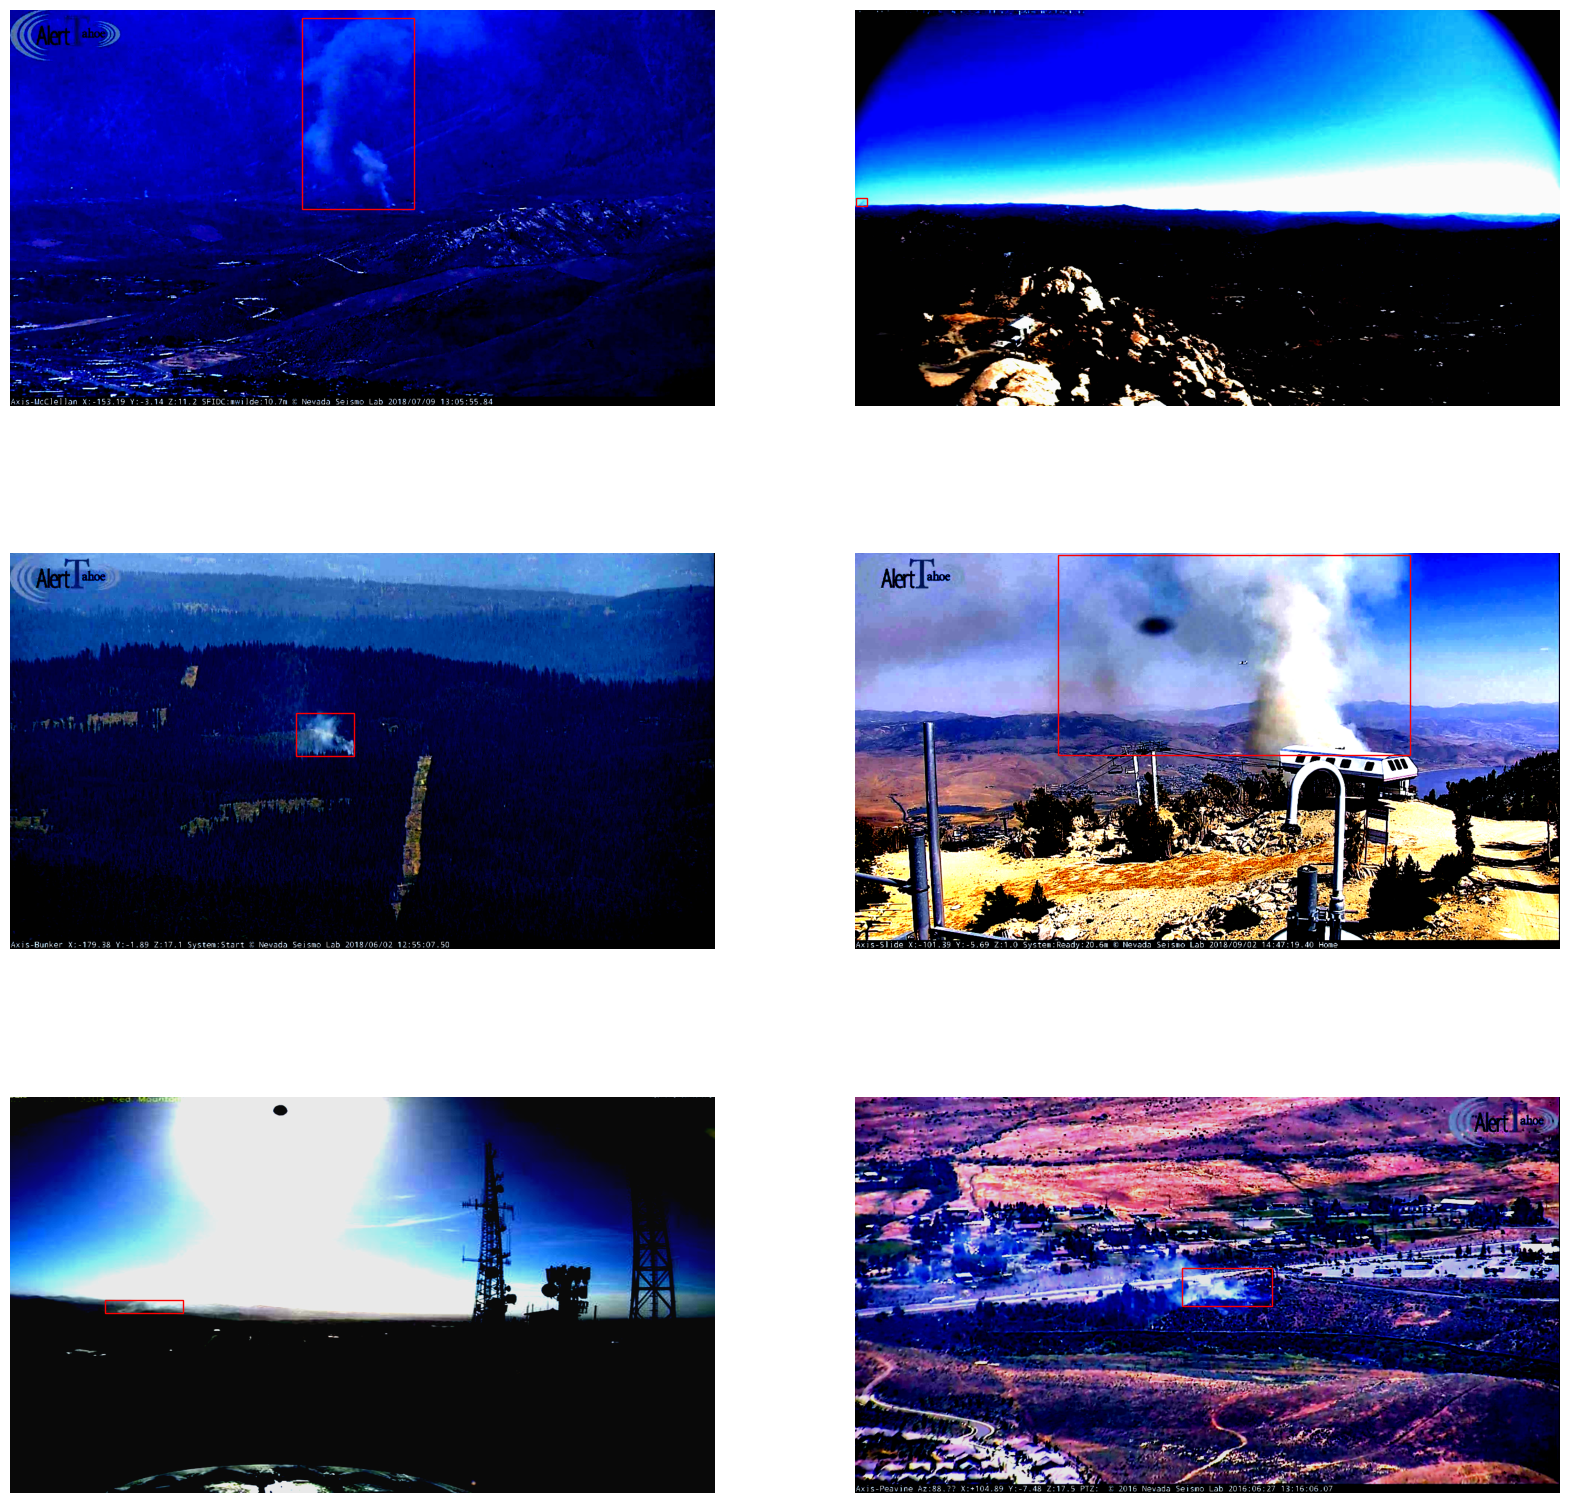

In [18]:
random.seed(20)
ax, fig = plt.subplots(3, 2, figsize=(20, 20))

# Display a sample image and label
for i in range(6):
    image, bbox = train_set[random.randint(0, len(train_set) - 1)]
    image = image.permute(1, 2, 0)
    i_fig = fig[i % 3, i // 3]
    i_fig.imshow(image)
    i_fig.axis('off')

    for j in range(len(bbox)):
        b_box = BoundingBox(bbox[j][0], bbox[j][1], bbox[j][2], bbox[j][3])
        i_fig.add_patch(b_box.plt_rectangle(image_width=image.shape[1], image_height=image.shape[0]))

plt.show()

### Preprocessing

### Augmentation

In [8]:
# FIXME

## Model(s)

### Architecture

In [9]:
# FIXME

### Loading

In [10]:
# FIXME

### Fine-tuning and training

In [11]:
# FIXME

### Evaluation

In [12]:
# FIXME

## Explanability

In [13]:
# FIXME